In [1]:
#imports
import cv2
import numpy as np
import sys

import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import numpy as np
from skimage.color import rgb2gray
from skimage.filters import median,threshold_otsu
from skimage.morphology import binary_closing,binary_opening 
from skimage.feature import canny
from skimage.measure import find_contours
from sklearn.cluster import KMeans
import skimage.io as io
import numpy as np
import random
from skimage import data, exposure, img_as_float
import xlwt
from xlwt import Workbook

In [2]:
#detect shape of contours
def detect(c):
        # initialize the shape name and approximate the contour
        shape = "unidentified"
        peri = cv2.arcLength(c, True)
        approx = cv2.approxPolyDP(c, 0.02 * peri, True)
        (x, y, w, h) = cv2.boundingRect(approx)
        ar = w / float(h)
        # if the shape is a triangle, it will have 3 vertices
        if len(approx) == 3:
            shape = "triangle"
        # if the shape has 4 vertices, it is either a square or
        # a rectangle
         
        elif len(approx) == 4:
            # compute the bounding box of the contour and use the
            # bounding box to compute the aspect ratio
          
            # a square will have an aspect ratio that is approximately
            # equal to one, otherwise, the shape is a rectangle
            shape = "square" if ar >= 0.95 and ar <= 1.05 else "rectangle"
        # if the shape is a pentagon, it will have 5 vertices
        elif len(approx) == 5:
            shape = "circle"
        # otherwise, we assume the shape is a circle
        else:
            shape = "circle"
        # return the name of the shape
        return shape

In [3]:
#show image
def show_images(images,titles=None):
    #This function is used to show image(s) with titles by sending an array of images and an array of associated titles.
    # images[0] will be drawn with the title titles[0] if exists
    n_ims = len(images)
    if titles is None: titles = ['(%d)' % i for i in range(1,n_ims + 1)]
    fig = plt.figure()
    n = 1
    for image,title in zip(images,titles):
        a = fig.add_subplot(1,n_ims,n)
        if image.ndim == 2: 
            plt.gray()
        plt.imshow(image)
        a.set_title(title)
        n += 1
    fig.set_size_inches(np.array(fig.get_size_inches()) * n_ims)
    plt.show()

In [4]:
#read image
path ="BubbleSheetTests/test11.jpg"
img = cv2.imread(path)
dim=(700,700)
image =img.copy()

In [5]:
def GrayScaleImage(img):
    #convert image to gray image
    imgGray=cv2.cvtColor(img,cv2.COLOR_BGR2GRAY)
    show_images([imgGray],["Gray Image"])
    return imgGray

In [6]:
def BluringImage(imgGray):
    # kernal size(3,3) & sigma = 1
    # may think again in img bluring
    imgBlur =cv2.GaussianBlur(imgGray,(3,3),1)
    show_images([imgBlur],["Image Bluring"])
    return imgBlur

In [7]:
def GraytoBinary(imgBlur):
    #BI-MODEL THRESHOLDING using two peaks 
    BinaryImage = cv2.adaptiveThreshold(imgBlur,255,cv2.ADAPTIVE_THRESH_GAUSSIAN_C,\
                cv2.THRESH_BINARY_INV,33,5)
    show_images([BinaryImage],["Binary Image"])
    return BinaryImage

In [8]:
def allContours(img ,BinaryImage):
    #get contours in image
    cnts ,hierarchy  = cv2.findContours(BinaryImage.copy(), cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    image= img.copy()
    # loop over the contour
    charsAndShapes =[]
    hierarchyShape= [] 
    
    for c in cnts:
 
        shape = detect(c)
 
        if shape!='rectangle' and shape !='square':
        #if shape in not rect or square => so assume chars and circle
            charsAndShapes.append(c)

        else:
             cv2.drawContours(image, [c], -1, (0, 255, 0), 1)

         # show the output image

    show_images([image],["Image"])
    return charsAndShapes

In [9]:
def charandCircles(img,BinaryImage,charsAndShapes):
    new_image= img.copy()
    circles=[]
    maskimage= np.zeros(BinaryImage.shape, dtype='uint8')
    #now i just have circles and chars
    for c in charsAndShapes:
        (x1, y1, w, h) = cv2.boundingRect(c)
        ar = w / float(h)
        # loop on contours if aspect ratio in accepted range so it circle
        if ar >= 0.75 and ar <= 1.4 :
            circles.append(c)
            # draw image with circle conoturs
            maskimage  [y1:y1+h, x1:x1+w] = BinaryImage[y1:y1+h, x1:x1+w]
            cv2.drawContours(new_image, [c], -1, (0, 255, 0), 1)
    show_images([new_image ,maskimage],["Image" ,"masked"]) 
    print(len(circles))
    return circles,maskimage

In [10]:
def ClosingCircles(maskimage,img):
    kernel = np.ones((2, 2), np.uint8)
    newmask2= cv2.morphologyEx(maskimage, cv2.MORPH_CLOSE, kernel,iterations=5)
    show_images([newmask2] ,["Image" ])
    cnts ,hierarchy  = cv2.findContours(newmask2.copy(), cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE)

    test_image= img.copy()

    print(len(cnts))
    for c in cnts:
        cv2.drawContours(test_image, [c], -1, (0, 255, 0), 2)
    show_images([newmask2 , test_image],["Image" ,"Test Image"])
    return cnts

In [11]:
def Circle(img,BinaryImage,circles):
    test_image= img.copy()
    mask = np.zeros(BinaryImage.shape, dtype='uint8')
    
    areas =[]
    reminder =[]
    questionCnts =[]
    (xmin,ymin),r =cv2.minEnclosingCircle(circles[0])
    for c in circles:
        x,y,w,h = cv2.boundingRect(c)
#         print("X"+ str(x)+" ,Y"+str(y))
        #store area of all contours
        areas.append(w*h)
    areas = np.float32(areas)       
    # Define criteria = ( type, max_iter = 10 , epsilon = 1.0 )
    criteria = (cv2.TERM_CRITERIA_EPS + cv2.TERM_CRITERIA_MAX_ITER, 5, 1.0)
    # Set flags (Just to avoid line break in the code)
    flags = cv2.KMEANS_RANDOM_CENTERS
    # Apply KMeans to clutser areas into 2 clutsers one for rows ,another for oultiers
    compactness,labels,centers = cv2.kmeans(areas,2,None,criteria,10,flags)       
    A = areas[labels.ravel()==0]
    B = areas[labels.ravel()==1]
    
    for i in range (0 ,len(circles)):
        if len(A)> len(B):
            if labels[i]==0:
                questionCnts.append(circles[i])
        else:
            if labels[i]==1:
                questionCnts.append(circles[i])
    print(len(questionCnts))           
     #some of contours may be repeated so just take it onece
     #this funnction needs to improve   
    reminder.append(questionCnts[0])
    for c in   questionCnts: 
        (x,y),radius = cv2.minEnclosingCircle(c)
        center = (int(x),int(y))
        if ( abs(x- xmin))>20 :
                reminder.append(c)
                xmin =x
#             else:
#                 ymin =y


    print(len(reminder))
    for c in reminder:
            x,y,w,h = cv2.boundingRect(c)
            cv2.drawContours(test_image, [c], -1, (0, 255, 0), 2)
            mask[y:y+h, x:x+w] = BinaryImage[y:y+h, x:x+w]            

    print(len(questionCnts)) 
    show_images([mask , test_image],["Image" ,"Test Image"])   
    return mask,reminder

In [12]:
def rows(maskimage,img,cluster=False):
    kernel = np.ones((1, 3), np.uint8)
    #apply high dilation on rows
    newmask2=cv2.dilate(maskimage, kernel, iterations=15) 
    show_images([newmask2],["Image"])
    # get conotours of this high dilated image
    cnts ,hierarchy  = cv2.findContours(newmask2.copy(), cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    if not cluster:
        return len(cnts)
    else:
        areas= []
        for c in cnts:
            x,y,w,h = cv2.boundingRect(c)
            #store area of all contours
            areas.append(w*h)
        areas = np.float32(areas)       
        # Define criteria = ( type, max_iter = 10 , epsilon = 1.0 )
        criteria = (cv2.TERM_CRITERIA_EPS + cv2.TERM_CRITERIA_MAX_ITER, 5, 1.0)
        # Set flags (Just to avoid line break in the code)
        flags = cv2.KMEANS_RANDOM_CENTERS
        # Apply KMeans to clutser areas into 2 clutsers one for rows ,another for oultiers
        compactness,labels,centers = cv2.kmeans(areas,2,None,criteria,10,flags)       
        A = areas[labels.ravel()==0]
        B = areas[labels.ravel()==1]
    
        if len(A)> len(B):
            return len(A)
        return len(B)
        
    #ROWS ARE DONE

In [13]:
def columns(maskimage,img,cluster=False):
    newkernel = np.ones((3, 1), np.uint8)
    #apply high dilation on image
    newmask3=cv2.dilate(maskimage, newkernel, iterations=15) 
    # get contours of image
    cnts ,hierarchy  = cv2.findContours(newmask3.copy(), cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    show_images([newmask3],["Image"])
    if not cluster:
        return len(cnts)
    else:
        areas= []
        for c in cnts:
            x,y,w,h = cv2.boundingRect(c)
            #store area of all contours
            areas.append(w*h)
        areas = np.float32(areas)       
        # Define criteria = ( type, max_iter = 10 , epsilon = 1.0 )
        criteria = (cv2.TERM_CRITERIA_EPS + cv2.TERM_CRITERIA_MAX_ITER, 5, 1.0)
        # Set flags (Just to avoid line break in the code)
        flags = cv2.KMEANS_RANDOM_CENTERS
        # Apply KMeans to clutser areas into 2 clutsers one for rows ,another for oultiers
        compactness,labels,centers = cv2.kmeans(areas,2,None,criteria,10,flags)       
        A = areas[labels.ravel()==0]
        B = areas[labels.ravel()==1]
    
        if len(A)> len(B):
            return len(A)
        return len(B)

In [14]:
def rows_sections(maskimage,img,cluster=False):
    kernel = np.ones((1, 3), np.uint8)
    #apply high dilation on rows
    newmask2=cv2.dilate(maskimage, kernel, iterations=60) 
    show_images([newmask2],["Image"])
    # get conotours of this high dilated image
    cnts ,hierarchy  = cv2.findContours(newmask2.copy(), cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    if not cluster:
        return len(cnts)
    else:
        areas= []
        for c in cnts:
            x,y,w,h = cv2.boundingRect(c)
            #store area of all contours
            areas.append(w*h)
        areas = np.float32(areas)       
        # Define criteria = ( type, max_iter = 10 , epsilon = 1.0 )
        criteria = (cv2.TERM_CRITERIA_EPS + cv2.TERM_CRITERIA_MAX_ITER, 5, 1.0)
        # Set flags (Just to avoid line break in the code)
        flags = cv2.KMEANS_RANDOM_CENTERS
        # Apply KMeans to clutser areas into 2 clutsers one for rows ,another for oultiers
        compactness,labels,centers = cv2.kmeans(areas,2,None,criteria,10,flags)       
        A = areas[labels.ravel()==0]
        B = areas[labels.ravel()==1]
    
        if len(A)> len(B):
            return len(A)
        return len(B)


In [15]:
def columns_sections(maskimage,img,cluster=False):
    kernel = np.ones((4, 1), np.uint8)
    #apply high dilation on rows
    newmask2=cv2.dilate(maskimage, kernel, iterations=20) 
    show_images([newmask2],["Image"])
    # get conotours of this high dilated image
    cnts ,hierarchy  = cv2.findContours(newmask2.copy(), cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    if not cluster:
        return len(cnts)
    else:
        areas= []
        for c in cnts:
            x,y,w,h = cv2.boundingRect(c)
            #store area of all contours
            areas.append(w*h)
        areas = np.float32(areas)       
        # Define criteria = ( type, max_iter = 10 , epsilon = 1.0 )
        criteria = (cv2.TERM_CRITERIA_EPS + cv2.TERM_CRITERIA_MAX_ITER, 5, 1.0)
        # Set flags (Just to avoid line break in the code)
        flags = cv2.KMEANS_RANDOM_CENTERS
        # Apply KMeans to clutser areas into 2 clutsers one for rows ,another for oultiers
        compactness,labels,centers = cv2.kmeans(areas,2,None,criteria,10,flags)       
        A = areas[labels.ravel()==0]
        B = areas[labels.ravel()==1]
    
        if len(A)> len(B):
            return len(A)
        return len(B)


In [16]:
def sort_contours(circles,reminder):
    questions =[]
    for c in circles:
        for r in reminder:
            (x, y, w, h) = cv2.boundingRect(c)
            (x1, y1, w1, h1) = cv2.boundingRect(r)
            if x==x1 and y==y1 and h==h1 and w==w1:
                questions.append(c)
                break
    return questions           

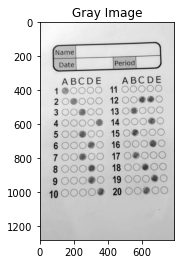

In [17]:
imgGray = GrayScaleImage(img)

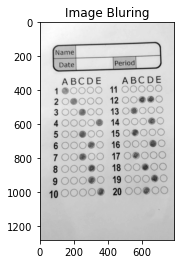

In [18]:
imgBlur = BluringImage(imgGray)

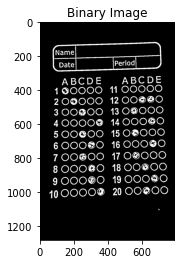

In [19]:
BinaryImage=GraytoBinary(imgBlur)

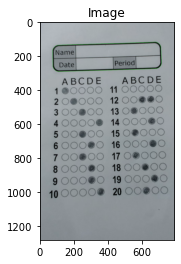

In [20]:
charsAndShapes=allContours(img,BinaryImage)

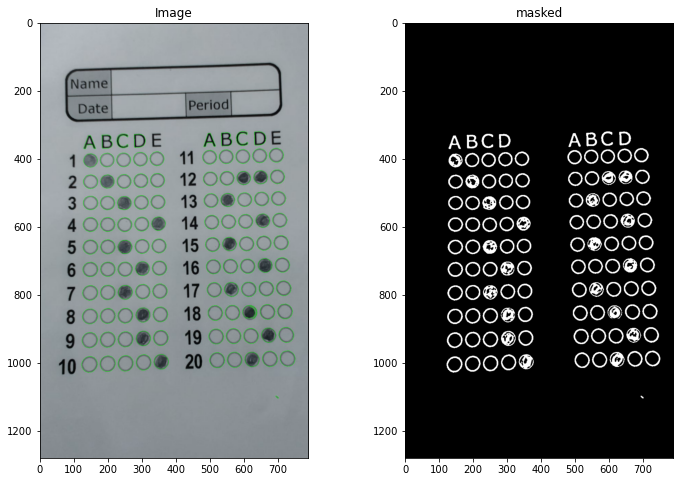

109


In [21]:
circles,maskimage=charandCircles(img,BinaryImage,charsAndShapes)

100
101
100


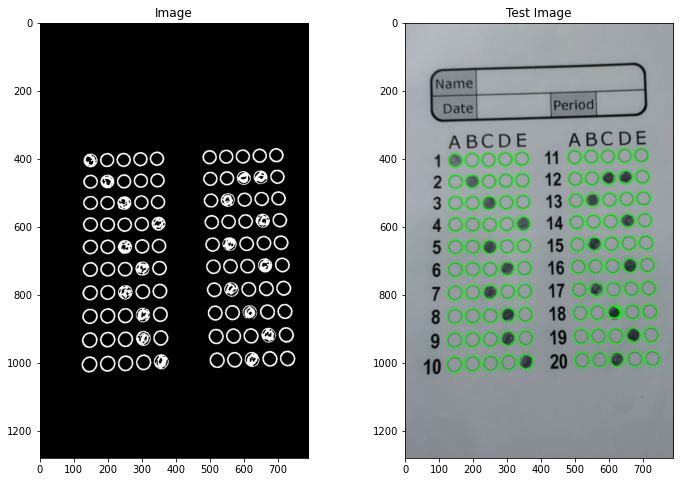

In [22]:
mask,reminder=Circle(img,maskimage,circles)

In [23]:
reminder=sort_contours(circles,reminder)

In [24]:
print(len(reminder))

100


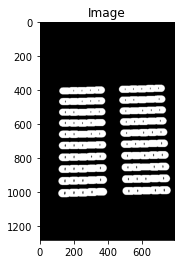

20


In [25]:
rows_number = rows(mask,img)
print(rows_number)

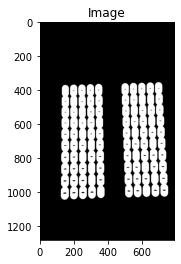

10


In [26]:
columns_number =columns(mask,img)
print(columns_number)

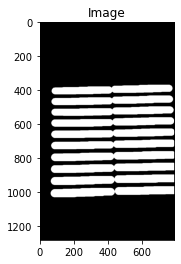

10


In [27]:
row_per_section =rows_sections(mask,img)
print(row_per_section)

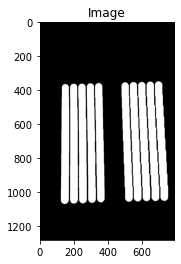

10


In [28]:
column_per_section= columns_sections(mask,img)
print(column_per_section)

In [29]:
def sort_columns(reminder,column_per_section):
    contours = []
    for i in range(0,len(reminder),column_per_section):
         cnts = reminder [i:i+column_per_section]
         arr =[]
         for c in cnts :
            (x, y, w, h) = cv2.boundingRect(c)
            arr.append(x)
         arr=np.sort(arr)
         print(arr)
         for e in arr:
                for cnt in cnts:
                     (x, y, w, h) = cv2.boundingRect(cnt)
                     if(x==e):
                        contours.append(cnt)
                        break
                
    return contours              
                

In [30]:
n_rows = rows_number/row_per_section
endpoint = rows_number/row_per_section
n_rows =column_per_section/n_rows

In [31]:
n_columns = columns_number/column_per_section
n_columns = row_per_section/n_columns

In [32]:
print(n_rows)
print(n_columns)

5.0
10.0


In [33]:
reminder=sort_columns(reminder,column_per_section)

[122 176 229 282 334 498 549 601 653 705]
[123 176 228 282 333 495 546 598 650 701]
[124 176 228 281 331 493 543 595 646 697]
[124 177 229 280 330 490 541 591 643 694]
[125 177 228 280 329 488 538 588 640 690]
[125 177 228 278 328 485 536 585 636 686]
[126 177 227 277 327 483 532 582 633 683]
[126 177 227 276 325 481 531 580 630 679]
[127 177 226 275 324 479 528 578 627 676]
[128 176 224 274 322 477 526 575 624 673]


In [40]:
def  get_answers(n_rows, n_columns,reminder,BinaryImage,row_per_section,endpoint,rows_number):
    marked = np.zeros(BinaryImage.shape, dtype='uint8')
    notmarked = np.zeros(BinaryImage.shape, dtype='uint8')
    n_rows =int(n_rows)
    count=0
    total = int(n_rows*n_columns)
    intial = int(row_per_section)
    savepoint =endpoint
#     sortedCnts,boundingBoxes =sort_contours(reminder)
    sortedCnts = reminder
    arr =np.zeros(shape=(rows_number, n_rows))
    print(arr.shape)
    for i in range(0,len(sortedCnts),n_rows):
        cnts = sortedCnts [i:i+n_rows]
        j = 0
        for c in cnts:
            
            (x, y, w, h) = cv2.boundingRect(c)
#             print("X"+str(x)+" ,Y"+str(y))
            mask = np.zeros([h, w], dtype='uint8')
            mask[0:h, 0:w] = BinaryImage[y:y+h, x:x+w] 
            imgHist = exposure.histogram(mask, nbins=256)
             
            if(imgHist[0][0]<imgHist[0][255]):
                count+=1
                arr[int(intial)-1][j]=1
                marked [y:y+h, x:x+w]=BinaryImage[y:y+h, x:x+w]
            else :
               
                notmarked[y:y+h, x:x+w]=BinaryImage[y:y+h, x:x+w]
            j =j +1        
#        print(count)     
#         show_images([marked,notmarked],["Marked","not marked"])
        intial+= row_per_section
#         print(intial)
#         if(intial-1)>=rows_number:
#                 endpoint=savepoint
#                 intial=intial-(endpoint) *row_per_section-1
                    
        endpoint -=1
        if endpoint ==0:
            endpoint=savepoint
            intial=intial-(endpoint) *row_per_section-1
   
    show_images([marked,notmarked],["Marked","not marked"]) 
    print(count)
    return arr
            

In [41]:
def generate_asnwsers(nquestions,nchoices):
    f = open("BubbleSheetTests/answers.txt","a")
    f.truncate(0)
    answers =[]
    for i in range(0,nquestions):
        choice =random.randint(1,nchoices) 
        answers.append(choice)
        f.write(str(choice))
        f.write('\n')
    f.close()
    return answers

In [59]:
def readanswers():
    f = open("BubbleSheetTests/answers.txt","r")
    answers =[]
    x= f.readlines()
    for i in range(0,len(x)):
        answers.append(int(x[i]))
    f.close()
    return answers

In [42]:
def createspreadsheet():
    # Workbook is created
    wb = Workbook()
    sheet1 = wb.add_sheet('Grades')
    return sheet1,wb

In [43]:
def wirtexcelsheet(questions,answers,nimage,sheet1,codes):
    minlength= min(len(questions), len(answers))
#     print(minlength)
    for i in range(0,minlength):
        arr=questions[i]
        index=np.where(arr == 1)
        print(index[0])
        print(answers[i])
        print("ok")
        if len(index[0])==1:
            if index[0][0]+1==answers[i]:
                sheet1.write(nimage,i+1,1)
            else:
                 sheet1.write(nimage,i+1,0)
        else :
            sheet1.write(nimage,i+1,0)
            
#     minlength = min(10,len(codes))  
#     t_matrix = zip(*codes)
#     code =""
#     for i in range(0,minlength):
#         arr=codes[i]
#         index=np.where(arr == 1)
#         number =index[0][0]+1
#         if number ==10:
#             code +='0'
#         else:
#             code += str(number)
            
#     sheet1.write(nimage,0,code)   
            
    
    
    

(20, 5)


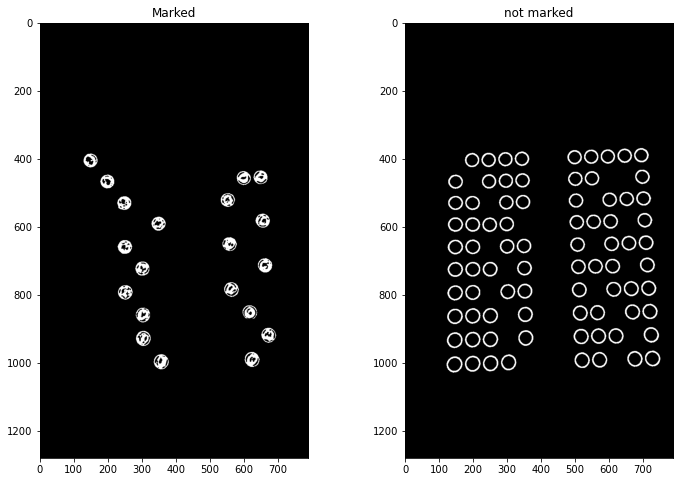

20


In [44]:
arr=get_answers(n_rows,n_columns,reminder,BinaryImage,row_per_section,endpoint,rows_number)

In [45]:
print(arr)

[[1. 0. 0. 0. 0.]
 [0. 1. 0. 0. 0.]
 [0. 0. 1. 0. 0.]
 [0. 0. 0. 0. 1.]
 [0. 0. 1. 0. 0.]
 [0. 0. 0. 1. 0.]
 [0. 0. 1. 0. 0.]
 [0. 0. 0. 1. 0.]
 [0. 0. 0. 1. 0.]
 [0. 0. 0. 0. 1.]
 [0. 0. 0. 0. 0.]
 [0. 0. 1. 1. 0.]
 [0. 1. 0. 0. 0.]
 [0. 0. 0. 1. 0.]
 [0. 1. 0. 0. 0.]
 [0. 0. 0. 1. 0.]
 [0. 1. 0. 0. 0.]
 [0. 0. 1. 0. 0.]
 [0. 0. 0. 1. 0.]
 [0. 0. 1. 0. 0.]]


In [46]:
def speratequestions(arr,n_columns):
    codes =[]
    n_columns =int(n_columns)
    questions =[]
    for i in range(0,n_columns):
        codes.append(arr[i])
    for i in range(n_columns,len(arr)):
        questions.append(arr[i])
    return codes,questions    

In [47]:
codes,questions=speratequestions(arr,n_columns)

In [48]:
print(codes)

[array([1., 0., 0., 0., 0.]), array([0., 1., 0., 0., 0.]), array([0., 0., 1., 0., 0.]), array([0., 0., 0., 0., 1.]), array([0., 0., 1., 0., 0.]), array([0., 0., 0., 1., 0.]), array([0., 0., 1., 0., 0.]), array([0., 0., 0., 1., 0.]), array([0., 0., 0., 1., 0.]), array([0., 0., 0., 0., 1.])]


In [49]:
print(questions)

[array([0., 0., 0., 0., 0.]), array([0., 0., 1., 1., 0.]), array([0., 1., 0., 0., 0.]), array([0., 0., 0., 1., 0.]), array([0., 1., 0., 0., 0.]), array([0., 0., 0., 1., 0.]), array([0., 1., 0., 0., 0.]), array([0., 0., 1., 0., 0.]), array([0., 0., 0., 1., 0.]), array([0., 0., 1., 0., 0.])]


In [50]:
def BubbleSheet(img,cluster,answers,sheet1,nimage,wb):
    imgGray = GrayScaleImage(img)
    imgBlur = BluringImage(imgGray)
    BinaryImage=GraytoBinary(imgBlur)
    charsAndShapes=allContours(img,BinaryImage)
    circles,maskimage=charandCircles(img,BinaryImage,charsAndShapes)
    mask,reminder=Circle(img,maskimage,circles)
    reminder=sort_contours(circles,reminder)
    print(len(reminder))
    rows_number = rows(mask,img,cluster)
    print(rows_number)
    columns_number =columns(mask,img,cluster)
    print(columns_number)
    row_per_section =rows_sections(mask,img,cluster)
    print(row_per_section)
    column_per_section= columns_sections(mask,img,cluster)
    print(column_per_section)
    n_rows = rows_number/row_per_section
    endpoint = rows_number/row_per_section
    n_rows =column_per_section/n_rows
    n_columns = columns_number/column_per_section
    n_columns = row_per_section/n_columns
    print(n_rows)
    print(n_columns)
    reminder=sort_columns(reminder,column_per_section)
    arr=get_answers(n_rows,n_columns,reminder,BinaryImage,row_per_section,endpoint,rows_number)
    codes,questions=speratequestions(arr,n_columns)
    wirtexcelsheet(questions,answers,nimage,sheet1,codes)
    wb.save('BubbleSheetTests/Grades.xls')
    print(codes)
    print(questions)
   
    
    
    
    
    
    

In [51]:
# send from previous layer
nimage=1
cluster= False

In [60]:
#run for one time
# n questions , n choices
#generate random answers for questions
# answers=generate_asnwsers(10,5)
answers=readanswers()
sheet1,wb=createspreadsheet()

In [61]:
print(answers)

[2, 3, 4, 2, 2, 4, 2, 3, 4, 1]


In [62]:
wirtexcelsheet(questions,answers,nimage,sheet1,codes)
wb.save('BubbleSheetTests/Grades.xls')

[]
2
ok
[2 3]
3
ok
[1]
4
ok
[3]
2
ok
[1]
2
ok
[3]
4
ok
[1]
2
ok
[2]
3
ok
[3]
4
ok
[2]
1
ok


In [ ]:
# BubbleSheet(img,cluster,answers,sheet1,nimage,wb)